In [17]:
import os
import pickle
import pandas as pd
import numpy as np
#
import matplotlib.pyplot as plt
from IPython.display import display
#
from sklearn import metrics
from sklearn.model_selection import train_test_split

# some settings for displaying Pandas results
pd.set_option('display.width', 2000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.precision', 4)
pd.set_option('display.max_colwidth', -1)

C:\Users\Hải Nam\AppData\Local\Temp\ipykernel_34136\1200070299.py:17: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


# 1. Load df_feat_labels

In [18]:
# D:\NEU\Năm 3\DATA PREP\PROJECT_DATAPREP\GITHUB REPO\KAGGLE_25_SPACE\model\df_features_label_fullfill_ext_lr_verion2_test.pkl.bz2
df_features_label = pd.read_pickle(
    'df_features_label_fullfill_ext_imputer.pkl.bz2', compression='bz2')

print(df_features_label.shape)

(307511, 682)


# 2. Feature Selection

In [19]:
df_features_label = df_features_label.replace(np.inf,np.nan)
df_features_label = df_features_label.replace(-np.inf,np.nan)

In [20]:
# check null
def check_missed_values(df):
    df_null_percentage = df.isnull().sum() / df.shape[0] * 100
    df_null_percentage = df_null_percentage.drop(
        df_null_percentage[df_null_percentage == 0].index).sort_values(ascending=False).reset_index()
    df_null_percentage.columns = ["Feature", "Percentage"]
    return df_null_percentage


null_df = check_missed_values(df_features_label)
columns_to_drop = null_df[null_df['Percentage'] > 90]['Feature'].tolist()
df_features_label.drop(columns=columns_to_drop, inplace=True)
df_features_label.shape

(307511, 681)

# 3. Get Train, Val, Test data

**Get list features**

In [21]:
meta_cols = ['SK_ID_CURR', 'TARGET', 'tvt_code']
ls_features = [
    cname for cname in df_features_label.columns if cname not in meta_cols]

#
print("Number of features: {}".format(len(ls_features)))

print(df_features_label.shape)
display(df_features_label.head().T)


Number of features: 678
(307511, 681)


,0,1,2,3,4
SK_ID_CURR,278621,139008,138348,64140,219374
TARGET,0,0,0,0,0
tvt_code,train,train,train,test,val
CREDIT_ACTIVE_Closed_mean,0.75,NaN,1.0,0.6667,0.5
CREDIT_ACTIVE_Active_mean,0.25,NaN,0.0,0.3333,0.5
...,...,...,...,...,...
train_test_num_fullfill_ext_lr_final_imputer_LAST_PHONE_CHANGE_YEAR,2.2685,NaN,3.0301,6.9479,2.9315
train_test_num_fullfill_ext_lr_final_imputer_DAYS_EMPLOYED_ANOM,False,NaN,False,False,False
train_test_num_fullfill_ext_lr_final_imputer_DAYS_EMPLOYED,-1188.0,NaN,-3038.0,-1588.0,-449.0
train_test_num_fullfill_ext_lr_final_imputer_YEARS_EMPLOYED,3.2548,NaN,8.3233,4.3507,1.2301


**Get train, val, test to train and evaluate model**

In [22]:
def get_Xy_from_df(df_input, ls_features, tvt_code):
    df_data = df_input[df_input["tvt_code"] == tvt_code].copy()

    #
    X = df_data[ls_features]
    y = df_data["TARGET"]

    return (X, y)

X_train, y_train = get_Xy_from_df(df_features_label, ls_features, "train")
X_val, y_val = get_Xy_from_df(df_features_label, ls_features, "val")
X_test, y_test = get_Xy_from_df(df_features_label, ls_features, 'test')


# 4. Define discrete and continuous variables lists to fillna 

**Null will be filled different on each dataset:**

   - Discrete features will be filled with most-frequent value.
   - Continous features will be filled with mean.

In [31]:
def get_discrete_continuos_columns(df_input,ls_features):
    ls_discrete_feat = []
    ls_continous_feat = []
    for fname in ls_features:
        if df_input[fname].fillna(0).nunique() == df_input[fname].fillna(0).astype('int').nunique():
            ls_discrete_feat.append(fname)
        else:
            ls_continous_feat.append(fname)
    return ls_discrete_feat,ls_continous_feat 


ls_discrete_feat, ls_continous_feat = get_discrete_continuos_columns(df_features_label,ls_features)
print(f'Num continuos feat : {len(ls_continous_feat)}' )
print(f'Num discrete feat : {len(ls_discrete_feat)}' )

Num continuos feat : 373
Num discrete feat : 305


# 5. Model Fitting

In [32]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression


# Create transformers for numerical and categorical features
discrete_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('std_scaler', StandardScaler())
])

continuos_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('std_scaler', StandardScaler())
])

# Combine transformers into a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('con', continuos_transformer, ls_continous_feat),
        ('dis', discrete_transformer, ls_discrete_feat)])

# Create a pipeline with the preprocessor and the logistic regression log_model
log_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(C=0.001,  tol=0.00001, penalty='l2'))
])

# Fit the log_model
log_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('con',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['CREDIT_ACTIVE_Closed_mean',
                                                   'CREDIT_ACTIVE_Active_mean',
                                                   'CREDIT_TYPE_Credit_card_mean',
                                                   'CREDIT_TYPE_Consumer_credit_mean',
                                                   'CREDIT_TYPE_Bad_loan_mean',
                                                   'CREDIT_TYPE_Car_loan_mean',
                                                   'CREDIT_TYPE_Mortgage_...
           

# 6. Model evalution

In [33]:
def test_model_on_dataset(tvt_code, model):
    X, y = get_Xy_from_df(df_features_label, ls_features, tvt_code)
    y_pred = model.predict_proba(X)[:, 1]

    # get values
    auc_value = metrics.roc_auc_score(y, y_pred)
    gini = 2 * auc_value - 1
    res01 = metrics.roc_curve(y, y_pred)

    # plot
    figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
    lw = 2
    ax1.plot(res01[0], res01[1], color="darkorange", lw=lw, label="ROC")
    ax1.plot([0, 1], [0, 1], color="navy",
             label="Random", lw=lw, linestyle="--")
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel("False Positive Rate")
    ax1.set_ylabel("True Positive Rate")
    ax1.set_title("AUC = %0.5f\nGini = %.5f" % (auc_value, gini), size=13)
    ax1.legend(loc="lower right")

    # prediction probability histogram
    ax2.set_title("{} set (size: {})".format(tvt_code, y.shape[0]))
    ax2.hist(y_pred, bins=200)

    plt.show()

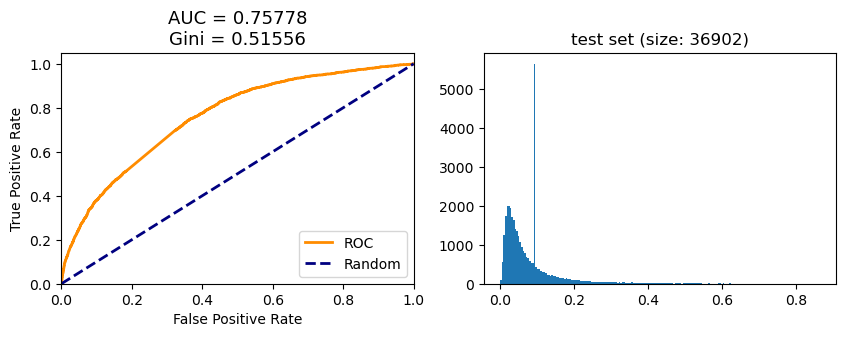

In [34]:
test_model_on_dataset('test', log_model)

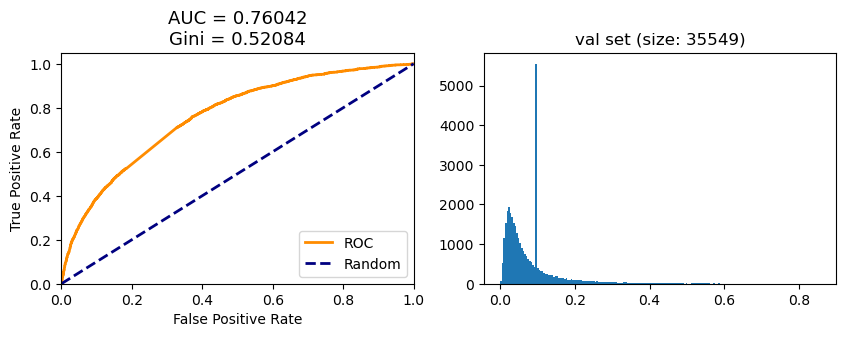

In [35]:
test_model_on_dataset('val', log_model)

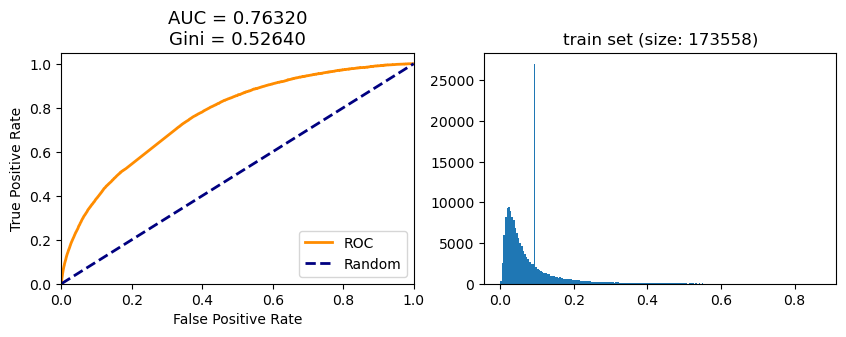

In [36]:
test_model_on_dataset('train',log_model)

*******


****

# Tunning

In [ ]:
best_params = {'tol': 0.0006913154134658764, 'solver': 'liblinear',
                    'max_iter': 221, 'C': 0.04967189873061729, 'penalty': 'l2'}
log_model = LogisticRegression(**best_params)
log_model.fit(X_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression

# Define numerical and categorical features
numerical_features = X_train.select_dtypes(
    include=['float64']).columns.to_list()
# numerical_features = [fname for fname in numerical_features if fname not in ['train_test_num_fullfill_ext_lr_2_EXT_SOURCE_1','train_test_num_fullfill_ext_lr_2_EXT_SOURCE_2','train_test_num_fullfill_ext_lr_2_EXT_SOURCE_3']]
categorical_features = X_train.select_dtypes(
    include=['object']).columns.to_list()


# Create transformers for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('std_scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

# Combine transformers into a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


# Create a pipeline with the preprocessor and the logistic regression log_model
log_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(**best_params))
])

# Fit the log_model
log_model.fit(X_train, y_train)


# # Define numerical and categorical features
# numerical_features = X_train.select_dtypes(include=['float64']).columns
# categorical_features = X_train.select_dtypes(include=['object']).columns

# # Create transformers for numerical and categorical features
# discreate_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('std_scaler', StandardScaler())
# ])

# continuos_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='median')),
#     ('std_scaler', StandardScaler())
# ])

# # Combine transformers into a preprocessor using ColumnTransformer
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('con', continuos_transformer, ls_continous_feat),
#         ('dis', discreate_transformer, ls_discrete_feat)])

# # Create a pipeline with the preprocessor and the logistic regression log_model
# log_model = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('classifier', LogisticRegression(C=0.001,  tol=0.00001, penalty='l2'))
# ])

# log_model = LogisticRegression(C=0.001,  tol=0.00001, penalty='l2')
# # Fit the log_model
# log_model.fit(X_train, y_train)

d:\Anaconda\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['CREDIT_ACTIVE_Closed_mean',
                                                   'CREDIT_ACTIVE_Active_mean',
                                                   'CREDIT_ACTIVE_Active_sum',
                                                   'CREDIT_ACTIVE_Closed_sum',
                                                   'CREDIT_TYPE_Credit_card_mean',
                                                   'CREDIT_TYPE_Credit_card_sum',
                                                   'CRED...
           

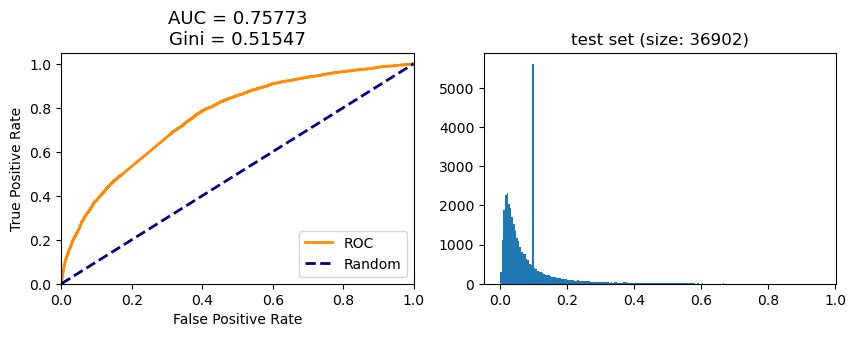

In [ ]:
test_model_on_dataset('test',log_model)

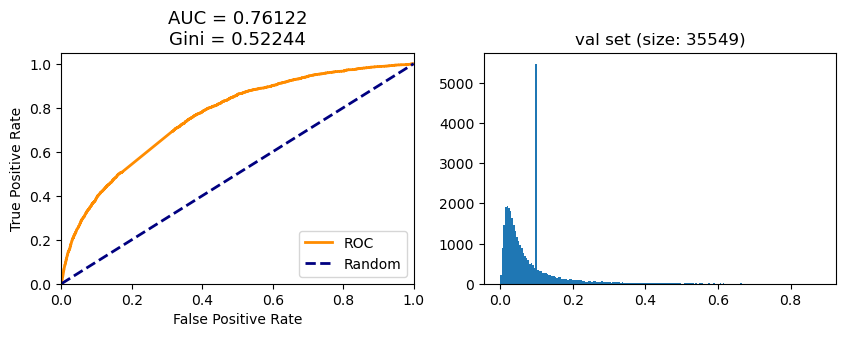

In [ ]:
test_model_on_dataset('val', log_model)

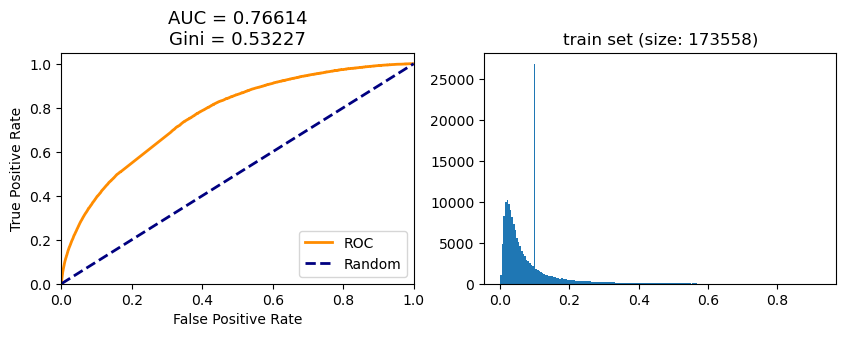

In [ ]:
test_model_on_dataset('train',log_model)

In [ ]:
X_kaggle_test = df_features_label.query(
    "tvt_code == 'kaggle_test'")[ls_features]
y_test_pred = log_model.predict_proba(X_kaggle_test)[:, 1]
y_test_pred

SK_IDs = df_features_label.query("tvt_code == 'kaggle_test'")[
    "SK_ID_CURR"].tolist()
df_submiss = pd.DataFrame({"SK_ID_CURR": SK_IDs, "TARGET": y_test_pred})
df_submiss.to_csv(
    "log_baseline_fillna_ext_3_goodbye_to_contest.csv", index=False)
df_submiss.head()

,SK_ID_CURR,TARGET
0,83659,0.1220
1,174814,0.0194
2,179486,0.1484
3,57038,0.0139
4,25672,0.0647


****

In [ ]:
# flag_doc_list =[]
# for fname in df_features_label.columns.to_list():
#     if fname.__contains__('_FLAG_DOCUMENT_'):
#         flag_doc_list.append(fname)

# flag_doc_list

In [ ]:
# df_features_label['train_test_num_fullfill_ext_lr_EXT_SOURCE_3']

****

# SelectKBest

In [ ]:
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import f_classif
# k = int(float(0.7)*X_train.shape[1])
# selector = SelectKBest(f_classif, k=k)
# selector.fit(X_train,y_train)

SelectKBest(k=340)

In [ ]:
# selected_feats = X_train.loc[:,selector.get_support()].columns.to_list()
# selected_feats

['CREDIT_ACTIVE_Closed_mean',
 'CREDIT_ACTIVE_Active_mean',
 'CREDIT_ACTIVE_Active_sum',
 'CREDIT_ACTIVE_Closed_sum',
 'CREDIT_TYPE_Credit_card_mean',
 'CREDIT_TYPE_Credit_card_sum',
 'CREDIT_ACTIVE_Closed_max',
 'CREDIT_TYPE_Consumer_credit_mean',
 'CREDIT_ACTIVE_Active_max',
 'CREDIT_TYPE_Credit_card_max',
 'CREDIT_TYPE_Consumer_credit_sum',
 'CREDIT_TYPE_Bad_loan_sum',
 'CREDIT_TYPE_Bad_loan_mean',
 'CREDIT_TYPE_Bad_loan_max',
 'CREDIT_TYPE_Car_loan_mean',
 'CREDIT_TYPE_Car_loan_sum',
 'CREDIT_TYPE_Car_loan_max',
 'CREDIT_TYPE_Mortgage_mean',
 'CREDIT_TYPE_Mortgage_sum',
 'CREDIT_TYPE_Mortgage_max',
 'CREDIT_ACTIVE_Bad_debt_mean',
 'DAYS_CREDIT_TO_YEARS_min',
 'DAYS_CREDIT_TO_YEARS_max',
 'DAYS_CREDIT_TO_YEARS_mean',
 'DAYS_CREDIT_TO_YEARS_std',
 'DAYS_CREDIT_TO_YEARS_median',
 'CREDIT_DAY_OVERDUE_TO_YEARS_min',
 'CREDIT_DAY_OVERDUE_TO_YEARS_max',
 'CREDIT_DAY_OVERDUE_TO_YEARS_mean',
 'CREDIT_DAY_OVERDUE_TO_YEARS_std',
 'CREDIT_DAY_OVERDUE_TO_YEARS_median',
 'DAYS_CREDIT_UPDATE_TO_Y

In [ ]:
# df_features_label.dtypes.value_counts()

float64    675
int64      2  
object     1  
dtype: int64

In [ ]:
# def get_Xy_from_df(df_input, ls_features, tvt_code):
#     df_data = df_input[df_input["tvt_code"] == tvt_code].copy()

#     #
#     X = df_data[ls_features]
#     y = df_data["TARGET"]

#     return (X, y)


# X_train, y_train = get_Xy_from_df(df_features_label, selected_feats, "train")
# X_val, y_val = get_Xy_from_df(df_features_label, selected_feats, "val")
# X_test, y_test = get_Xy_from_df(df_features_label, selected_feats, 'test')

In [ ]:
# X_train.shape[1]

340

In [ ]:
# X_test.shape[1]

340

In [ ]:
# \

LogisticRegression(C=0.001, tol=1e-05)

In [ ]:
# def test_model_on_dataset(tvt_code,ls_features,model):
#     X, y = get_Xy_from_df(df_features_label, ls_features, tvt_code)
#     y_pred = model.predict_proba(X)[:, 1]

#     # get values
#     auc_value = metrics.roc_auc_score(y, y_pred)
#     gini = 2 * auc_value - 1
#     res01 = metrics.roc_curve(y, y_pred)

#     # plot
#     figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
#     lw = 2
#     ax1.plot(res01[0], res01[1], color="darkorange", lw=lw, label="ROC")
#     ax1.plot([0, 1], [0, 1], color="navy",
#              label="Random", lw=lw, linestyle="--")
#     ax1.set_xlim([0.0, 1.0])
#     ax1.set_ylim([0.0, 1.05])
#     ax1.set_xlabel("False Positive Rate")
#     ax1.set_ylabel("True Positive Rate")
#     ax1.set_title("AUC = %0.5f\nGini = %.5f" % (auc_value, gini), size=13)
#     ax1.legend(loc="lower right")

#     # prediction probability histogram
#     ax2.set_title("{} set (size: {})".format(tvt_code, y.shape[0]))
#     ax2.hist(y_pred, bins=200)

#     plt.show()

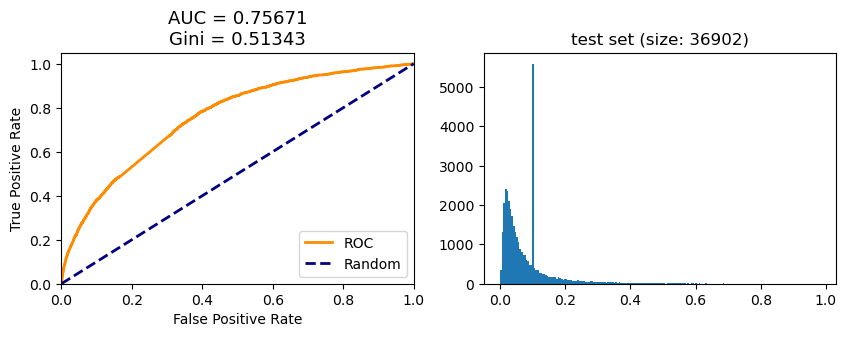

In [ ]:
test_model_on_dataset('test',ls_features,log_model)

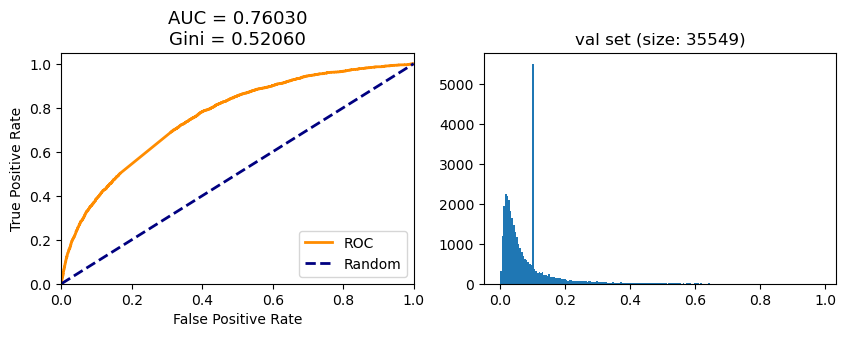

In [ ]:
test_model_on_dataset('val', ls_features,log_model)

In [ ]:
# from sklearn.model_selection import GridSearchCV

# Grid Search CV

In [ ]:
# hyperparameters = {
#     'solver' :'liblinear',
#     'max_iter': [100,300,500],
#     'C':[0.001,0.01,0.05],
#     'penalty' : ['l2']
#     # Add other hyperparmeters to tune
# }

In [ ]:
import optuna
from sklearn.metrics import roc_auc_score


def objective(trial):
  hyperparameters = {
      'tol': trial.suggest_uniform('tol', 1e-6, 1e-3),
      # Replace with 'choices' parameter
      'solver': trial.suggest_categorical('solver', ['liblinear']),
      'max_iter': trial.suggest_int('max_iter', 100, 2500),
      'C': trial.suggest_loguniform('C', 0.001, 100),
      'penalty': trial.suggest_categorical('penalty', ['l2']),
      'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
      'random_state': trial.suggest_categorical('random_state', [0, 42, 2021, 555]),
      'n_jobs': -1
  }

  model = LogisticRegression(**hyperparameters)
  model.fit(X_train, y_train)
  preds = model.predict_proba(X_train)[:, 1]

  roc_auc = roc_auc_score(y_train, preds)
  return roc_auc


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)

# Get the best hyperparameters
best_params = study.best_params
print("Best parameters found: ", best_params)

# Train the model with the best hyperparameters on the full training set
final_model = LogisticRegression(**best_params)
final_model.fit(X_train, y_train)

# Calculate the ROC-AUC score
roc_auc = roc_auc_score(y_test, final_model.predict_proba(X_test)[:, 1])

# Calculate Gini index
gini_index = 2 * roc_auc - 1

print('Best Hyperparameters:', best_params)
print('ROC-AUC on Validation Set:', roc_auc)
print('Gini Index on Validation Set:', gini_index)

[I 2023-12-03 20:12:09,099] A new study created in memory with name: no-name-9adc405e-6e2c-420d-9398-e611cf6ab539
C:\Users\Hải Nam\AppData\Local\Temp\ipykernel_10696\2596783970.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'tol': trial.suggest_uniform('tol', 1e-6, 1e-3),
C:\Users\Hải Nam\AppData\Local\Temp\ipykernel_10696\2596783970.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 0.001, 100),
d:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(
[I 2023-12-03 20:13:09,652] Trial 0 finished with value: 0.7

Best parameters found:  {'tol': 0.00038646904300700276, 'solver': 'liblinear', 'max_iter': 1748, 'C': 13.71433000310647, 'penalty': 'l2', 'fit_intercept': True, 'random_state': 0}
Best Hyperparameters: {'tol': 0.00038646904300700276, 'solver': 'liblinear', 'max_iter': 1748, 'C': 13.71433000310647, 'penalty': 'l2', 'fit_intercept': True, 'random_state': 0}
ROC-AUC on Validation Set: 0.7567130775574221
Gini Index on Validation Set: 0.5134261551148442


In [ ]:
# df_features_label.drop(columns=flag_doc_list,inplace=True)

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression

# Define numerical and categorical features
numerical_features = X_train.select_dtypes(include=['float64']).columns.to_list()
# numerical_features = [fname for fname in numerical_features if fname not in ['train_test_num_fullfill_ext_lr_2_EXT_SOURCE_1','train_test_num_fullfill_ext_lr_2_EXT_SOURCE_2','train_test_num_fullfill_ext_lr_2_EXT_SOURCE_3']]
categorical_features = X_train.select_dtypes(include=['object']).columns.to_list()


# Create transformers for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('std_scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

# Combine transformers into a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


# Create a pipeline with the preprocessor and the logistic regression log_model
hyper_para = {'tol': 0.0009445930828582952, 'solver': 'liblinear',
              'max_iter': 130, 'C': 0.025921784465010124, 'penalty': 'l2'}
log_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(**hyper_para))
])

# Fit the log_model
log_model.fit(X_train, y_train)


# # Define numerical and categorical features
# # numerical_features = X_train.select_dtypes(include=['float64']).columns
# # categorical_features = X_train.select_dtypes(include=['object']).columns

# # # Create transformers for numerical and categorical features
# # discreate_transformer = Pipeline(steps=[
# #     ('imputer', SimpleImputer(strategy='most_frequent')),
# #     ('std_scaler', StandardScaler())
# # ])

# # continuos_transformer = Pipeline(steps=[
# #     ('imputer', SimpleImputer(strategy='median')),
# #     ('std_scaler', StandardScaler())
# # ])

# # # Combine transformers into a preprocessor using ColumnTransformer
# # preprocessor = ColumnTransformer(
# #     transformers=[
# #         ('con', continuos_transformer, ls_continous_feat),
# #         ('dis', discreate_transformer, ls_discrete_feat)])

# # Create a pipeline with the preprocessor and the logistic regression log_model
# # log_model = Pipeline(steps=[
# #     ('preprocessor', preprocessor),
# #     ('classifier', LogisticRegression(C=0.001,  tol=0.00001, penalty='l2'))
# # ])
# best_params = {'tol': 0.00038646904300700276, 'solver': 'liblinear', 'max_iter': 1748,
#                'C': 13.71433000310647, 'penalty': 'l2', 'fit_intercept': True, 'random_state': 0}
# log_model = LogisticRegression(**best_params)
# # Fit the log_model
# log_model.fit(X_train, y_train)

d:\Anaconda\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['CREDIT_ACTIVE_Closed_mean',
                                                   'CREDIT_ACTIVE_Active_mean',
                                                   'CREDIT_ACTIVE_Active_sum',
                                                   'CREDIT_ACTIVE_Closed_sum',
                                                   'CREDIT_TYPE_Credit_card_mean',
                                                   'CREDIT_TYPE_Credit_card_sum',
                                                   'CRED...
           

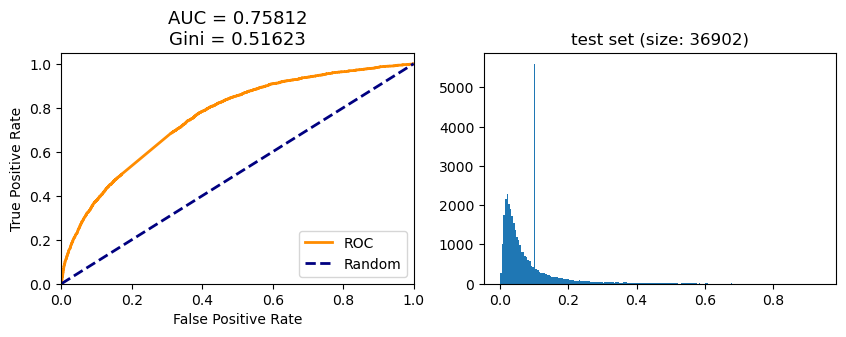

In [ ]:
test_model_on_dataset('test',log_model)

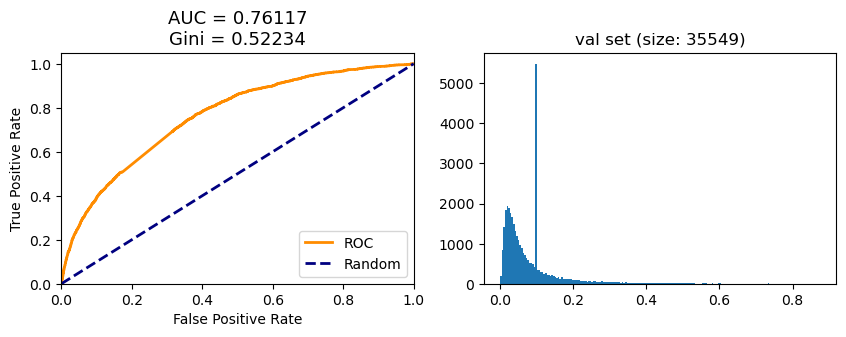

In [ ]:
test_model_on_dataset('val',log_model)

# Submit

In [ ]:
X_kaggle_test = df_features_label.query(
    "tvt_code == 'kaggle_test'")[ls_features]
y_test_pred = log_model.predict_proba(X_kaggle_test)[:, 1]
y_test_pred

SK_IDs = df_features_label.query("tvt_code == 'kaggle_test'")[
    "SK_ID_CURR"].tolist()
df_submiss = pd.DataFrame({"SK_ID_CURR": SK_IDs, "TARGET": y_test_pred})
df_submiss.to_csv(
    "log_baseline_fillna_ext_3_capybara.csv", index=False)
df_submiss.head()

,SK_ID_CURR,TARGET
0,83659,0.1158
1,174814,0.0191
2,179486,0.1613
3,57038,0.0127
4,25672,0.0850


In [ ]:
if len(df_features_label.columns.to_list()) == len(set(df_features_label.columns.to_list())):
    print('No duplicated columns')

No duplicated columns


In [ ]:
df_features_label.columns.to_list()

['SK_ID_CURR',
 'TARGET',
 'tvt_code',
 'CREDIT_ACTIVE_Closed_mean',
 'CREDIT_ACTIVE_Active_mean',
 'CREDIT_ACTIVE_Active_sum',
 'CREDIT_ACTIVE_Closed_sum',
 'CREDIT_TYPE_Credit_card_mean',
 'CREDIT_TYPE_Credit_card_sum',
 'CREDIT_ACTIVE_Closed_max',
 'CREDIT_TYPE_Consumer_credit_mean',
 'CREDIT_ACTIVE_Active_max',
 'CREDIT_TYPE_Credit_card_max',
 'CREDIT_TYPE_Consumer_credit_sum',
 'CREDIT_TYPE_Bad_loan_sum',
 'CREDIT_TYPE_Bad_loan_mean',
 'CREDIT_TYPE_Bad_loan_max',
 'CREDIT_TYPE_Car_loan_mean',
 'CREDIT_TYPE_Car_loan_sum',
 'CREDIT_TYPE_Car_loan_max',
 'CREDIT_TYPE_Mortgage_mean',
 'CREDIT_TYPE_Mortgage_sum',
 'CREDIT_TYPE_Mortgage_max',
 'CREDIT_CURRENCY_currency_1_sum',
 'CREDIT_TYPE_Consumer_credit_max',
 'CREDIT_ACTIVE_Bad_debt_mean',
 'CREDIT_ACTIVE_Bad_debt_max',
 'CREDIT_ACTIVE_Bad_debt_sum',
 'DAYS_CREDIT_TO_YEARS_min',
 'DAYS_CREDIT_TO_YEARS_max',
 'DAYS_CREDIT_TO_YEARS_mean',
 'DAYS_CREDIT_TO_YEARS_std',
 'DAYS_CREDIT_TO_YEARS_median',
 'CREDIT_DAY_OVERDUE_TO_YEARS_min',
 

In [ ]:
# df_features_label.query("tvt_code == 'kaggle_test'")[['train_test_num_fullfill_ext_lr_2_EXT_SOURCE_1','train_test_num_fullfill_ext_lr_2_EXT_SOURCE_2','train_test_num_fullfill_ext_lr_2_EXT_SOURCE_3']]

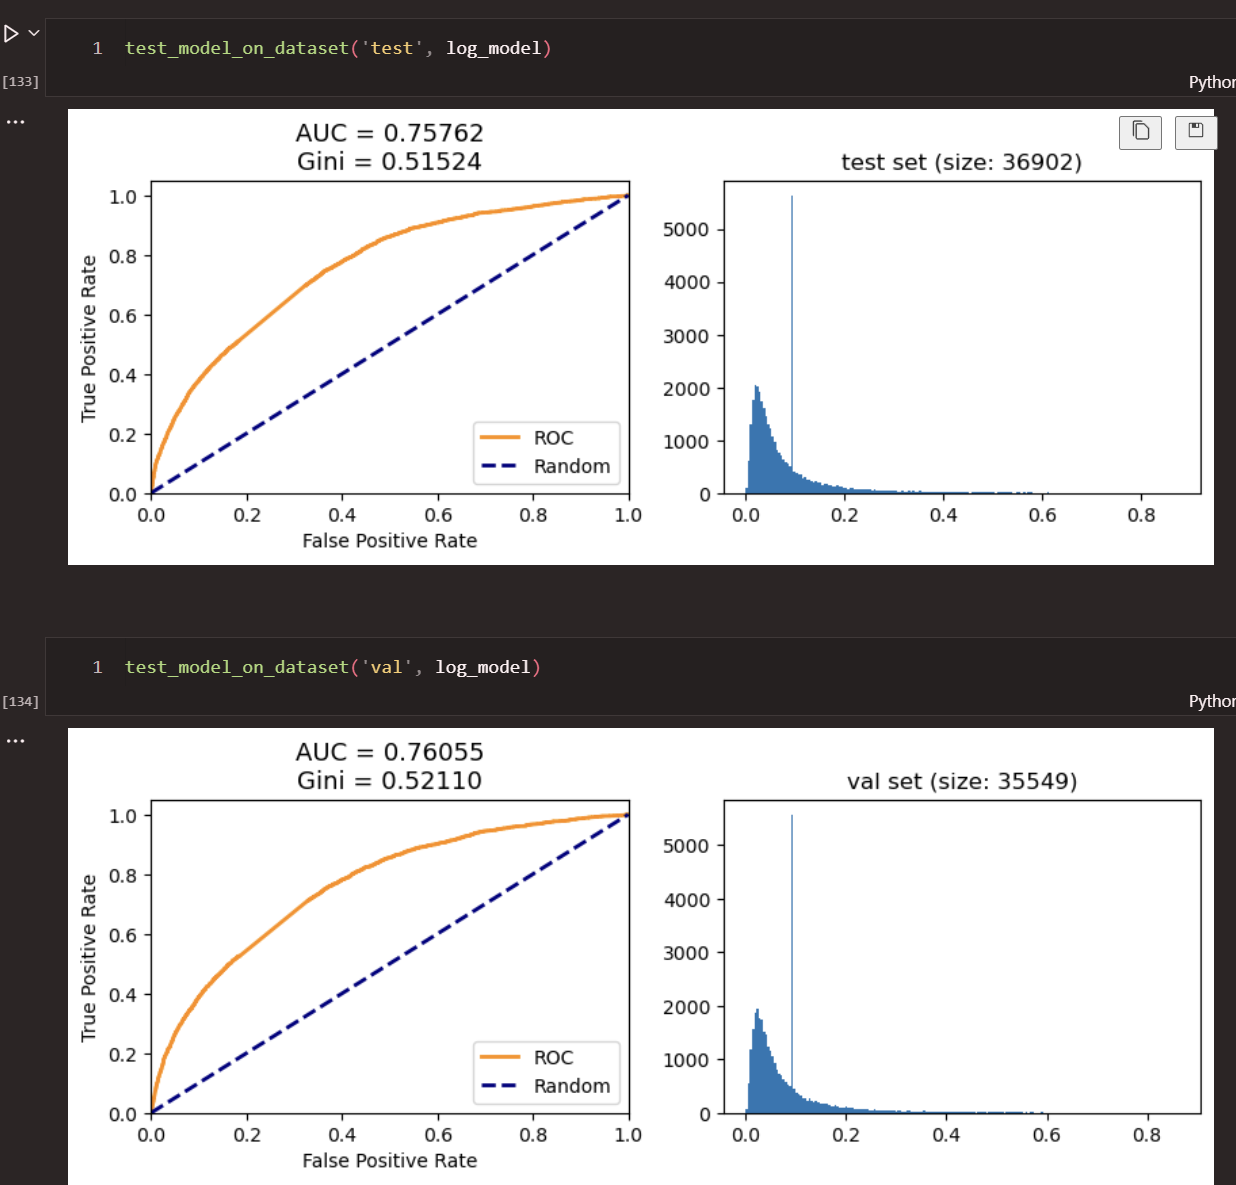

In [ ]:
# Tính VIF cho từng feature
vif = pd.DataFrame(
    data=X_train.iloc[:, :-1].var(ddof=1),
    index=X_train.iloc[:, :-1].columns,
    columns=['VIF']
)

# In ra các feature có VIF lớn hơn 10
vif[vif > 10].sort_values()

TypeError: sort_values() missing 1 required positional argument: 'by'